# Import

In [1]:
import EpiAnno
import os
import tensorflow as tf
import hickle as hkl
from tensorflow_probability import edward2 as ed
import numpy as np
import hdf5storage
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
data_forebrain = hdf5storage.loadmat('../data/train_forebrain.mat')
train_data = data_forebrain['sc_mat']
train_label = data_forebrain['sc_label']
le = preprocessing.LabelEncoder()
train_target = le.fit_transform(train_label)

In [3]:
data_cerebellum = hdf5storage.loadmat('../data/test_cerebellum.mat')
cerebellum_data = data_cerebellum['sc_mat']
cerebellum_label = data_cerebellum['sc_label']
data_wholebrain1 = hdf5storage.loadmat('../data/test_wholebrain1.mat')
wholebrain1_data = data_wholebrain1['sc_mat']
wholebrain1_label = data_wholebrain1['sc_label']
data_wholebrain2 = hdf5storage.loadmat('../data/test_wholebrain2.mat')
wholebrain2_data = data_wholebrain2['sc_mat']
wholebrain2_label = data_wholebrain2['sc_label']
#data_prefrontalcortex = hdf5storage.loadmat('../data/test_prefrontalcortex.mat')
#prefrontalcortex_data = data_prefrontalcortex['sc_mat']
#prefrontalcortex_label = data_prefrontalcortex['sc_label']

In [4]:
cerebellum_target = le.transform(cerebellum_label)
wholebrain1_target = le.transform(wholebrain1_label)
wholebrain2_target = le.transform(wholebrain2_label)
#prefrontalcortex_target = le.transform(prefrontalcortex_label)

create data_train for training

In [5]:
dtype = np.float32
n_classes = max(train_target)+1
Data = {i: np.array(train_data[train_target == i,:])  for i in range(n_classes)}
sample_shape = {i: sum(train_target == i)  for i in range(n_classes)}# sample_shape for each class
data_train = Data[0]
for i in range(n_classes-1):
    data_train=np.vstack((data_train,Data[i+1]))

# Train EpiAnno model

In [6]:
seed = 1024
np.random.seed(seed)
tf.set_random_seed(seed)
latent_dim = 10
learning_rate = 0.015
num_epochs = 60000
verbose = True

get Variables of EpiAnno

In [7]:
qmu , qsigma,qz,qw,qnoise = EpiAnno.Q(latent_dim,data_train.shape[1],n_classes,sample_shape)
qmu_dict = {v.distribution.name.split("_")[0].split("/")[0][1:]: v for v in qmu}
qw_dict = {v.distribution.name.split("_")[0].split("/")[0][1:]: v for v in qw}
qz_dict = {v.distribution.name.split("_")[0].split("/")[0][1:]: v for v in qz}

Instructions for updating:
The `rate` parameter is deprecated. Use `scale` instead.The `rate` parameter was always interpreted as a `scale` parameter, but erroneously misnamed.


set Variables to EpiAnnp, then get the ELBO

In [8]:
with ed.interception(EpiAnno.set_values(**qmu_dict,sigma=qsigma,**qw_dict,x = data_train,\
                                          **qz_dict,noise = qnoise)):
        pmu,psigma,pz,pw,pnoise,px = EpiAnno.EpiAnno(10,data_train.shape[1],n_classes,sample_shape)
elbo = EpiAnno.ELBO(pmu,psigma,pz,pw,pnoise,px,qmu , qsigma,qz,qw,qnoise,data_train.shape[1],data_train.shape[0])

set gpu_use and train the EpiAnno model, then get the last 1000 parameters of the model from training

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
if tf.test.is_gpu_available()==True:
    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth=True
    tf.Session(config=tf_config)
with tf.Session(config=tf_config) as sess:
        posterior_mu,posterior_sigma,posterior_qw = EpiAnno.train(qmu,qsigma,qw,elbo,sess,learning_rate,num_epochs,verbose)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

.
0 epochs	-1494638.208 k..........
100 epochs	-1191966.08 k..........
200 epochs	-1396246.528 k..........
300 epochs	-8917877784.576 k..........
400 epochs	-296787.584 k..........
500 epochs	-1057086701.568 k..........
600 epochs	-123262.072 k..........
700 epochs	-68167.12 k..........
800 epochs	-37653.136 k..........
900 epochs	-61849.58 k..........
1000 epochs	-40918.996 k..........
1100 epochs	-323312.448 k..........
1200 epochs	-133571.48 k..........
1300 epochs	-143634.992 k..........
1400 epochs	-4859942.4 k..........
1500 epochs	-383142.72 k..........
1600 epochs	-101823.656 k..........
1700 epochs	-43359.952 k..........
1800 epochs	-44924.976 k..........
1900 epochs	-71334.496 k..........
2000 epochs	-34818.784 k..........
2100 epochs	-74387.928 k..........
2200 epochs	-36586.808 k..........
2300 epochs	-3556636.672 k..........
2400 epochs	-27797.094 k..........
2500 epochs	-269262

21000 epochs	-19410.744 k..........
21100 epochs	-33360.952 k..........
21200 epochs	-34760.368 k..........
21300 epochs	-21327.358 k..........
21400 epochs	-18182.88 k..........
21500 epochs	-37219.052 k..........
21600 epochs	-25610.34 k..........
21700 epochs	-26828.25 k..........
21800 epochs	-24304.948 k..........
21900 epochs	-33615.852 k..........
22000 epochs	-27964.588 k..........
22100 epochs	-20513.318 k..........
22200 epochs	-21231.144 k..........
22300 epochs	-21334.846 k..........
22400 epochs	-40922.984 k..........
22500 epochs	-25582.326 k..........
22600 epochs	-21595.664 k..........
22700 epochs	-21984.668 k..........
22800 epochs	-21805.904 k..........
22900 epochs	-24591.396 k..........
23000 epochs	-25031.332 k..........
23100 epochs	-36764.688 k..........
23200 epochs	-23537.206 k..........
23300 epochs	-34173.184 k..........
23400 epochs	-20066.456 k..........
23500 epochs	-20081.204 k..........
23600 epochs	-26928.914 k..........
23700 epochs	-21966.608 k......

43800 epochs	-23605.77 k..........
43900 epochs	-25450.342 k..........
44000 epochs	-23797.316 k..........
44100 epochs	-25066.552 k..........
44200 epochs	-25168.426 k..........
44300 epochs	-25478.19 k..........
44400 epochs	-23205.56 k..........
44500 epochs	-25367.476 k..........
44600 epochs	-24445.908 k..........
44700 epochs	-25645.14 k..........
44800 epochs	-23536.02 k..........
44900 epochs	-25681.53 k..........
45000 epochs	-24794.138 k..........
45100 epochs	-23380.896 k..........
45200 epochs	-26435.236 k..........
45300 epochs	-21743.524 k..........
45400 epochs	-25890.586 k..........
45500 epochs	-23674.806 k..........
45600 epochs	-23661.096 k..........
45700 epochs	-24285.392 k..........
45800 epochs	-25732.072 k..........
45900 epochs	-23049.06 k..........
46000 epochs	-23778.17 k..........
46100 epochs	-24159.528 k..........
46200 epochs	-21655.144 k..........
46300 epochs	-25899.582 k..........
46400 epochs	-25000.512 k..........
46500 epochs	-22924.272 k..........


# Predict labels by EpiAnno

In [10]:
def predict_label(posterior_qw,posterior_mu,posterior_sigma,test_data,le):
    select = np.random.randint(0,1000,10)
    pred_target_test = []
    for i in range(10):
        pred_z_test = EpiAnno.predict_z(posterior_qw[select[i]],test_data)
        pred_target_test.append(EpiAnno.predict_target(posterior_mu[select[i]],posterior_sigma[select[i]],pred_z_test))
    pred_target_test = np.array(pred_target_test)
    pred_target = []
    for i in range(pred_target_test.shape[1]):
        b = np.bincount(pred_target_test[:,i])
        pred_target.append(np.argmax(b))
    pred_label = le.inverse_transform(np.array(pred_target))
    return pred_label

In [11]:
cerebellum_pred_label = predict_label(posterior_qw,posterior_mu,posterior_sigma,cerebellum_data,le)
wholebrain1_pred_label = predict_label(posterior_qw,posterior_mu,posterior_sigma,wholebrain1_data,le)
wholebrain2_pred_label = predict_label(posterior_qw,posterior_mu,posterior_sigma,wholebrain2_data,le)
#prefrontalcortex_pred_label = predict_label(posterior_qw,posterior_mu,posterior_sigma,prefrontalcortex_data,le)

In [12]:
from sklearn import metrics
print("accuracy of cere bellum dataset: ",metrics.accuracy_score(cerebellum_pred_label,cerebellum_label))
print("accuracy of whole brain 1 dataset: ",metrics.accuracy_score(wholebrain1_pred_label,wholebrain1_label))
print("accuracy of whole brain 2 dataset: ",metrics.accuracy_score(wholebrain2_pred_label,wholebrain2_label))
#print("accuracy of prefrontal cortex dataset: ",metrics.accuracy_score(prefrontalcortex_pred_label,prefrontalcortex_label))

accuracy of cere bellum dataset:  0.8451053283767038
accuracy of whole brain 1 dataset:  0.9011351153423655
accuracy of whole brain 2 dataset:  0.9130695443645084


In [13]:
print("kappa of cere bellum dataset: ",metrics.cohen_kappa_score(cerebellum_pred_label,cerebellum_label))
print("kappa of whole brain 1 dataset: ",metrics.cohen_kappa_score(wholebrain1_pred_label,wholebrain1_label))
print("kappa of whole brain 2 dataset: ",metrics.cohen_kappa_score(wholebrain2_pred_label,wholebrain2_label))
#print("kappa of prefrontal cortex dataset: ",metrics.cohen_kappa_score(prefrontalcortex_pred_label,prefrontalcortex_label))

kappa of cere bellum dataset:  0.7787625176003052
kappa of whole brain 1 dataset:  0.8686512406051267
kappa of whole brain 2 dataset:  0.8862585719915613


In [14]:
def f1_score(test_label,pred_label):
    unique = np.unique(test_label)
    f1_score_list = []
    for label in unique:
        f1 = metrics.f1_score(np.array(test_label)==label,np.array(pred_label)==label)
        f1_score_list.append(f1)
    return np.median(f1_score_list)
print("mF1 of cere bellum dataset: ",f1_score(cerebellum_pred_label,cerebellum_label))
print("mF1 of whole brain 1 dataset: ",f1_score(wholebrain1_pred_label,wholebrain1_label))
print("mF1 of whole brain 2 dataset: ",f1_score(wholebrain2_pred_label,wholebrain2_label))
#print("mF1 of prefrontal cortex dataset: ",f1_score(prefrontalcortex_pred_label,prefrontalcortex_label))

mF1 of cere bellum dataset:  0.8787878787878788
mF1 of whole brain 1 dataset:  0.963144963144963
mF1 of whole brain 2 dataset:  0.9454545454545454


# Visualization of latent features

In [15]:
forebrain_latent_feature = EpiAnno.predict_z(posterior_qw[0],train_data)

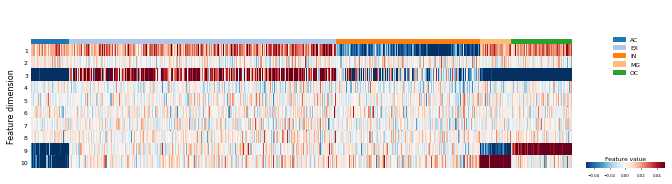

In [16]:
import heatmap
heatmap.plot_heatmap(forebrain_latent_feature.T, np.array(train_label), vmin=-0.05, vmax=0.05, figsize=(10, 3), legend_font=6, cmap='RdBu_r', 
             bbox_to_anchor=(1.1, 1.1), position=(0.98, 0.2, .11, .03), ncol=1, 
             yticklabels=range(1, 11), row_cluster=False, ylabel='Feature dimension', cax_title='Feature value',save = False)

# UMAP visualization

forebrain(training) dataset

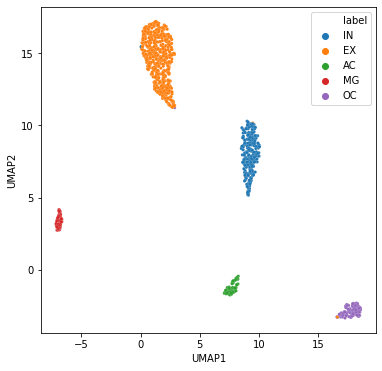

In [17]:
import umap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
u_trans = umap.UMAP(n_components=2,random_state = 1234)
train_data_umap = u_trans.fit_transform(forebrain_latent_feature)
df = {'UMAP1':train_data_umap[:, 0], 'UMAP2':train_data_umap[:, 1], 'label':train_label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label",s=10,linewidth=0.1,hue_order = ['IN','EX','AC','MG','OC'], data=df)
ax.legend()

In [18]:
cerebellum_latent_feature = EpiAnno.predict_z(posterior_qw[0],cerebellum_data)
wholebrain1_latent_feature = EpiAnno.predict_z(posterior_qw[0],wholebrain1_data)
wholebrain2_latent_feature = EpiAnno.predict_z(posterior_qw[0],wholebrain2_data)
#prefrontalcortex_latent_feature = EpiAnno.predict_z(posterior_qw[0],prefrontalcortex_data)
cerebellum_umap = u_trans.transform(cerebellum_latent_feature)
wholebrain1_umap = u_trans.transform(wholebrain1_latent_feature)
wholebrain2_umap = u_trans.transform(wholebrain2_latent_feature)
#prefrontalcortex_umap = u_trans.transform(prefrontalcortex_latent_feature)

whole brain 1(test) dataset

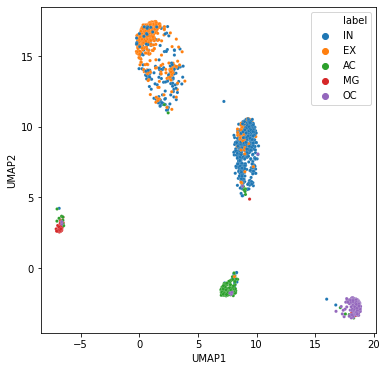

In [19]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
df = {'UMAP1':wholebrain1_umap[:, 0], 'UMAP2':wholebrain1_umap[:, 1], 'label':wholebrain1_label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label",s=10,linewidth=0.1,hue_order = ['IN','EX','AC','MG','OC'], data=df)
ax.legend()